# Comprehensive Feature Selection - Customer Churn Dataset

This notebook performs extensive feature selection using multiple techniques:
- Statistical Tests (Chi-Square, ANOVA, Mutual Information)
- Filter Methods (Variance Threshold, Correlation)
- Wrapper Methods (RFE, Sequential Feature Selection)
- Embedded Methods (Lasso, Ridge, Tree-based Feature Importance)
- Feature Importance from Multiple Models
- Comprehensive Feature Ranking and Selection

In [1]:
from pathlib import Path
import os

SRC = str(Path.cwd().parent)
os.chdir(SRC)
print(SRC)

E:\DS lectures\customer-churn-ds\customer_churn_prediction


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import (
    SelectKBest, chi2, f_classif, mutual_info_classif,
    VarianceThreshold, RFE, RFECV, SelectFromModel,
    SequentialFeatureSelector
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Data Loading and Preprocessing

In [3]:
# Load the dataset
df = pd.read_csv('data/raw/customer_churn_dataset_with_date.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (100000, 11)

First few rows:


,customer_id,age,tenure_months,monthly_charges,total_charges,contract_type,internet_service,support_calls,late_payments,churn,Date
0,1,46.0000,8.0000,63.6700,102.9600,Month-to-month,Fiber optic,3.0000,0,0,2025-01-01
1,2,38.0000,28.0000,93.6600,2830.1500,One year,Fiber optic,0.0000,1,1,2025-01-02
2,3,48.0000,5.0000,122.3700,924.3600,Month-to-month,DSL,1.0000,0,0,2025-01-03
3,4,58.0000,37.0000,66.4500,1990.9500,One year,Fiber optic,5.0000,2,0,2025-01-04
4,5,37.0000,2.0000,57.3200,20.0300,One year,Fiber optic,0.0000,1,1,2025-01-05


In [4]:
# Check for missing values
print("Missing Values:")
missing_summary = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df)) * 100
})
print(missing_summary[missing_summary['Missing_Count'] > 0])

Missing Values:
                 Missing_Count  Percentage
age                       3000      3.0000
monthly_charges           3000      3.0000
total_charges             3000      3.0000
support_calls             3000      3.0000


In [5]:
# Create a copy for processing
df_processed = df.copy()

# Drop customer_id and Date as they're not predictive features
df_processed = df_processed.drop(['customer_id', 'Date'], axis=1, errors='ignore')

# Separate features and target
X = df_processed.drop('churn', axis=1)
y = df_processed['churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nChurn distribution:")
print(y.value_counts())
print(f"\nChurn rate: {y.mean()*100:.2f}%")

Features shape: (100000, 8)
Target shape: (100000,)

Churn distribution:
churn
0    60748
1    39252
Name: count, dtype: int64

Churn rate: 39.25%


In [6]:
# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

Numerical features (6): ['age', 'tenure_months', 'monthly_charges', 'total_charges', 'support_calls', 'late_payments']

Categorical features (2): ['contract_type', 'internet_service']


In [7]:
# Handle missing values
# For numerical features: fill with median
for col in numerical_features:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna(X[col].median())
        print(f"Filled {col} missing values with median: {X[col].median():.3f}")

# For categorical features: fill with mode
for col in categorical_features:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna(X[col].mode()[0])
        print(f"Filled {col} missing values with mode: {X[col].mode()[0]}")

print("\nMissing values after imputation:")
print(X.isnull().sum().sum())

Filled age missing values with median: 40.000
Filled monthly_charges missing values with median: 70.280
Filled total_charges missing values with median: 1055.735
Filled support_calls missing values with median: 1.000

Missing values after imputation:
0


In [8]:
categorical_features


['contract_type', 'internet_service']

In [9]:
# Encode categorical features
X_encoded = X.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"\nEncoded {col}:")
    print(f"  Original values: {X[col].unique()}")
    print(f"  Encoded values: {X_encoded[col].unique()}")

print(f"\nEncoded dataset shape: {X_encoded.shape}")


Encoded contract_type:
  Original values: <StringArray>
['Month-to-month', 'One year', 'Two year']
Length: 3, dtype: str
  Encoded values: [0 1 2]

Encoded internet_service:
  Original values: <StringArray>
['Fiber optic', 'DSL', 'No']
Length: 3, dtype: str
  Encoded values: [1 0 2]

Encoded dataset shape: (100000, 8)


In [10]:
# Create train-test split for model-based feature selection
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining set churn rate: {y_train.mean()*100:.2f}%")
print(f"Test set churn rate: {y_test.mean()*100:.2f}%")

Training set size: (80000, 8)
Test set size: (20000, 8)

Training set churn rate: 39.25%
Test set churn rate: 39.25%


In [11]:
X_train

,age,tenure_months,monthly_charges,total_charges,contract_type,internet_service,support_calls,late_payments
30559,65.0000,1.0000,77.2400,-115.3600,0,1,0.0000,2
91975,48.0000,20.0000,52.4200,1383.5800,1,0,3.0000,0
64301,46.0000,13.0000,93.7800,1174.8700,0,2,5.0000,2
50813,30.0000,4.0000,19.9800,304.8100,0,2,1.0000,0
14487,58.0000,5.0000,94.0300,922.7900,0,0,2.0000,0
...,...,...,...,...,...,...,...,...
91782,20.0000,2.0000,59.9700,238.9800,0,1,3.0000,1
35964,34.0000,92.0000,79.4800,7137.6300,1,1,2.0000,2
55976,45.0000,4.0000,40.8900,-174.2500,1,1,0.0000,1
87734,36.0000,5.0000,76.8300,437.5700,0,1,3.0000,0


In [12]:
# Scale features for certain algorithms
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Data scaled successfully!")

Data scaled successfully!


## 2. Statistical Tests for Feature Selection

### 2.1 Chi-Square Test (for categorical features)

Chi-Square Test for All Features

            Feature  Chi2_Score  P_Value Significant
0     contract_type   5095.6022   0.0000         Yes
1  internet_service    588.0635   0.0000         Yes


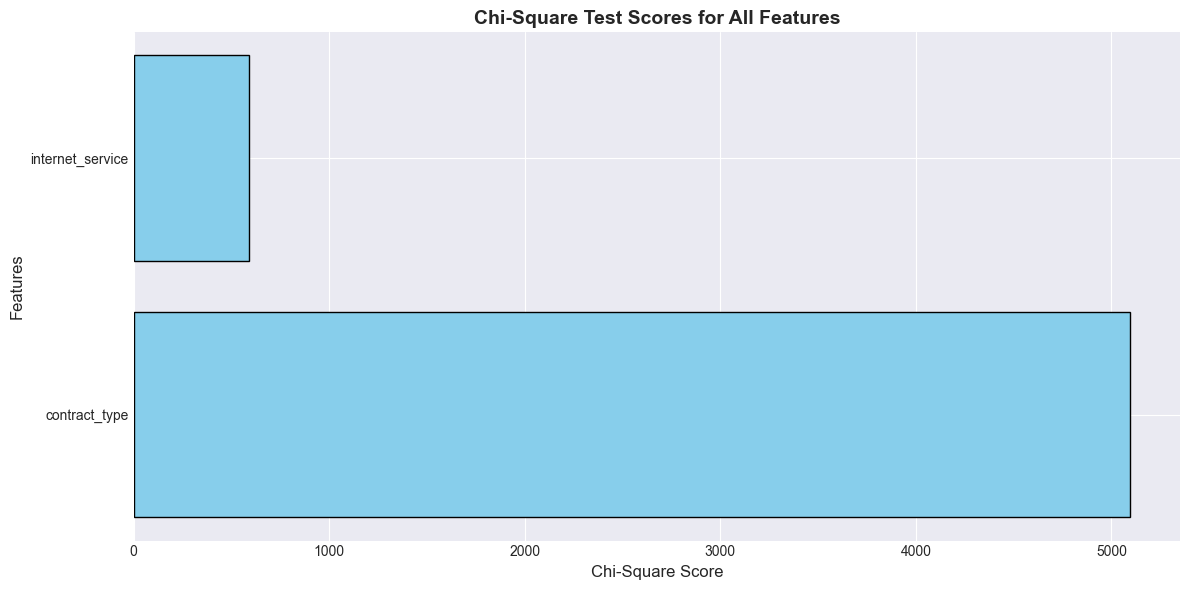

In [13]:
# Chi-Square Test
print("Chi-Square Test for All Features\n")
print("="*80)

chi2_scores = []
chi2_pvalues = []

for col in categorical_features:
    # Ensure non-negative values for chi2 test
    X_positive = X_encoded[[col]] - X_encoded[[col]].min() + 0.01
    
    selector = SelectKBest(score_func=chi2, k='all')
    selector.fit(X_positive, y)
    
    chi2_scores.append(selector.scores_[0])
    chi2_pvalues.append(selector.pvalues_[0])

chi2_results = pd.DataFrame({
    'Feature': categorical_features,
    'Chi2_Score': chi2_scores,
    'P_Value': chi2_pvalues,
    'Significant': ['Yes' if p < 0.05 else 'No' for p in chi2_pvalues]
}).sort_values('Chi2_Score', ascending=False)

print(chi2_results)

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(chi2_results['Feature'], chi2_results['Chi2_Score'], color='skyblue', edgecolor='black')
plt.xlabel('Chi-Square Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Chi-Square Test Scores for All Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.2 ANOVA F-Test

ANOVA F-Test for All Features

            Feature   F_Score  P_Value Significant
4     contract_type 4416.2144   0.0000         Yes
5  internet_service  801.1151   0.0000         Yes
1     tenure_months  403.9572   0.0000         Yes
3     total_charges  250.6037   0.0000         Yes
6     support_calls  170.2360   0.0000         Yes
7     late_payments   54.0480   0.0000         Yes
0               age    0.0737   0.7860          No
2   monthly_charges    0.0040   0.9497          No


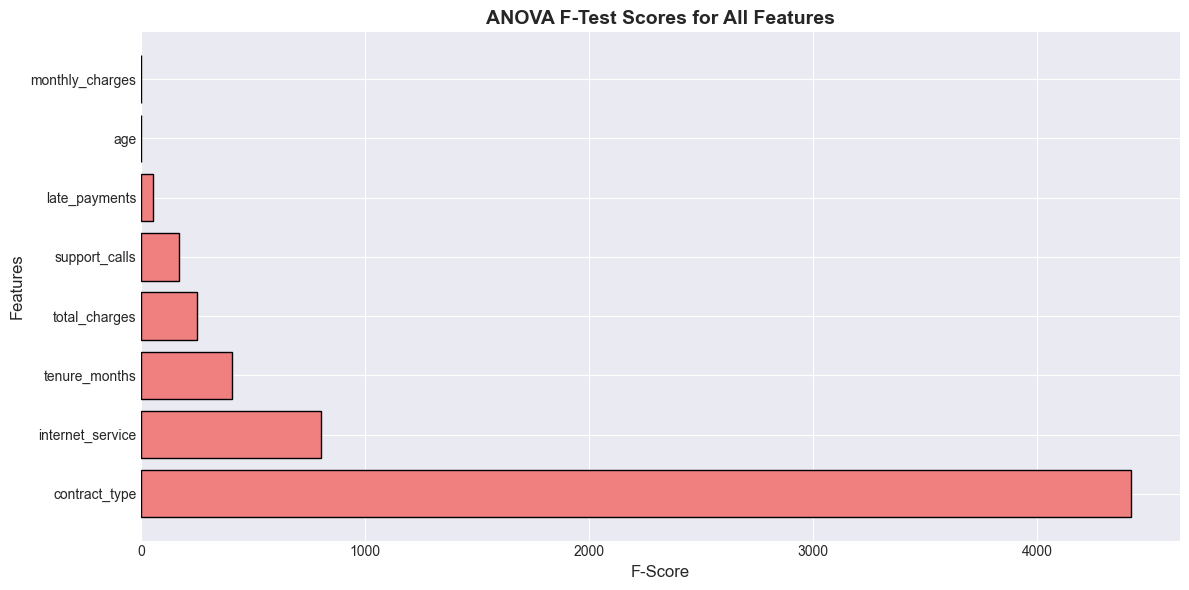

In [14]:
# ANOVA F-Test
print("ANOVA F-Test for All Features\n")
print("="*80)

selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(X_train, y_train)

f_scores = selector_f.scores_
f_pvalues = selector_f.pvalues_

f_results = pd.DataFrame({
    'Feature': X_train.columns,
    'F_Score': f_scores,
    'P_Value': f_pvalues,
    'Significant': ['Yes' if p < 0.05 else 'No' for p in f_pvalues]
}).sort_values('F_Score', ascending=False)

print(f_results)

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(f_results['Feature'], f_results['F_Score'], color='lightcoral', edgecolor='black')
plt.xlabel('F-Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('ANOVA F-Test Scores for All Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.3 Mutual Information

Mutual Information for All Features

            Feature  MI_Score
4     contract_type    0.0331
5  internet_service    0.0255
7     late_payments    0.0037
6     support_calls    0.0030
3     total_charges    0.0026
0               age    0.0017
1     tenure_months    0.0009
2   monthly_charges    0.0000


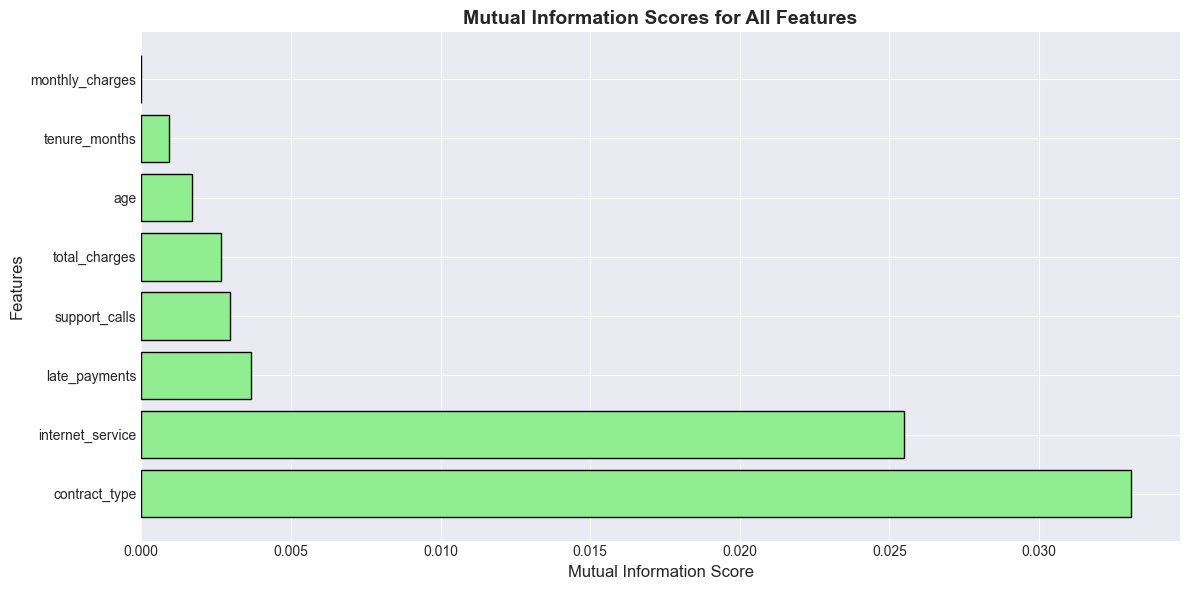

In [15]:
# Mutual Information
print("Mutual Information for All Features\n")
print("="*80)

mi_scores = mutual_info_classif(X_train, y_train, random_state=RANDOM_STATE)

mi_results = pd.DataFrame({
    'Feature': X_train.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print(mi_results)

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(mi_results['Feature'], mi_results['MI_Score'], color='lightgreen', edgecolor='black')
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Mutual Information Scores for All Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Filter Methods

### 3.1 Variance Threshold

Variance Threshold Analysis

            Feature     Variance
0     total_charges 4284747.1391
1   monthly_charges    2231.5480
2     tenure_months     543.1758
3               age     132.4288
4     support_calls       1.4677
5     late_payments       0.8089
6     contract_type       0.5473
7  internet_service       0.4108

Features with variance < 0.01:
None


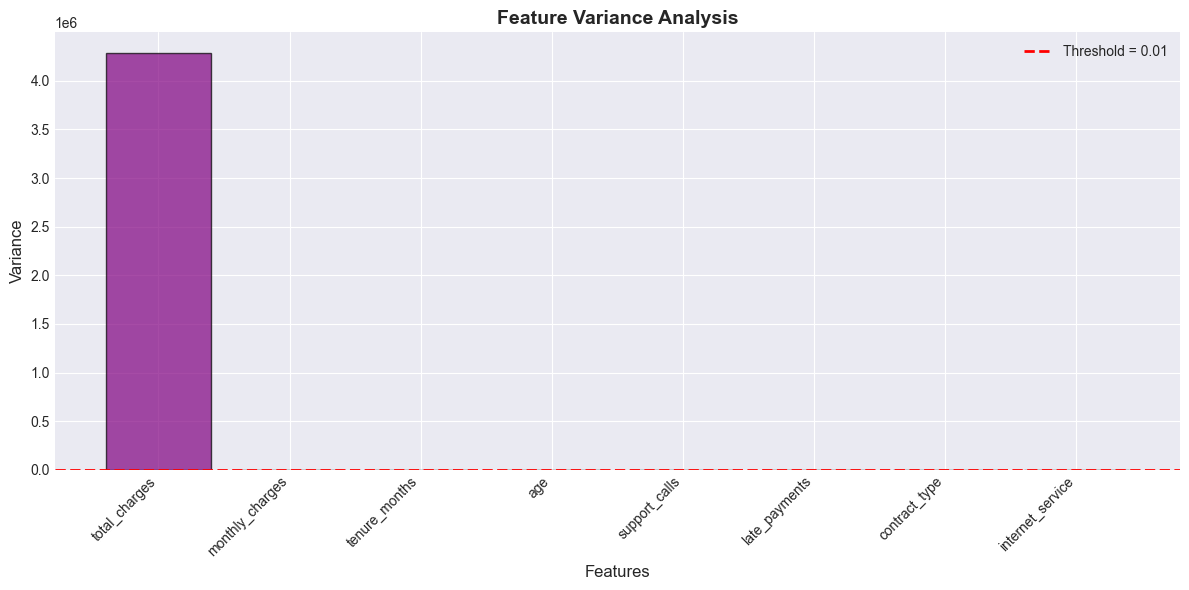

In [16]:
# Variance Threshold
print("Variance Threshold Analysis\n")
print("="*80)

# Calculate variance for each feature
variances = X_train.var().sort_values(ascending=False)
variance_df = pd.DataFrame({
    'Feature': variances.index,
    'Variance': variances.values
})

print(variance_df)

# Apply variance threshold (e.g., 0.01)
threshold = 0.01
selector_var = VarianceThreshold(threshold=threshold)
selector_var.fit(X_train)

low_variance_features = X_train.columns[~selector_var.get_support()].tolist()
print(f"\nFeatures with variance < {threshold}:")
print(low_variance_features if low_variance_features else "None")

# Visualize
plt.figure(figsize=(12, 6))
plt.bar(variance_df['Feature'], variance_df['Variance'], color='purple', alpha=0.7, edgecolor='black')
plt.axhline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold}')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.title('Feature Variance Analysis', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

### 3.2 Correlation Analysis

Correlation with Target Variable

            Feature  Abs_Correlation
0     contract_type           0.2287
1  internet_service           0.0996
2     tenure_months           0.0709
3     total_charges           0.0559
4     support_calls           0.0461
5     late_payments           0.0260
6               age           0.0010
7   monthly_charges           0.0002


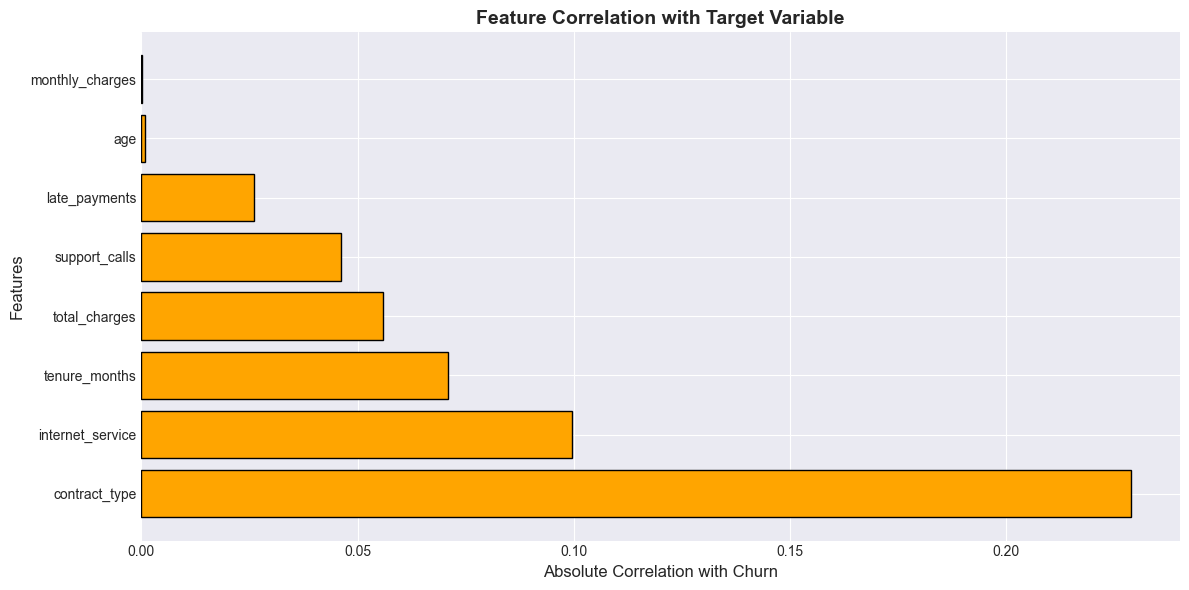

In [17]:
# Correlation with target
print("Correlation with Target Variable\n")
print("="*80)

# Calculate correlation with target
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
corr_df = pd.DataFrame({
    'Feature': correlations.index,
    'Abs_Correlation': correlations.values
})

print(corr_df)

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(corr_df['Feature'], corr_df['Abs_Correlation'], color='orange', edgecolor='black')
plt.xlabel('Absolute Correlation with Churn', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Correlation with Target Variable', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Feature-to-Feature Correlation Matrix

Highly correlated feature pairs (|r| > 0.8):
  None found


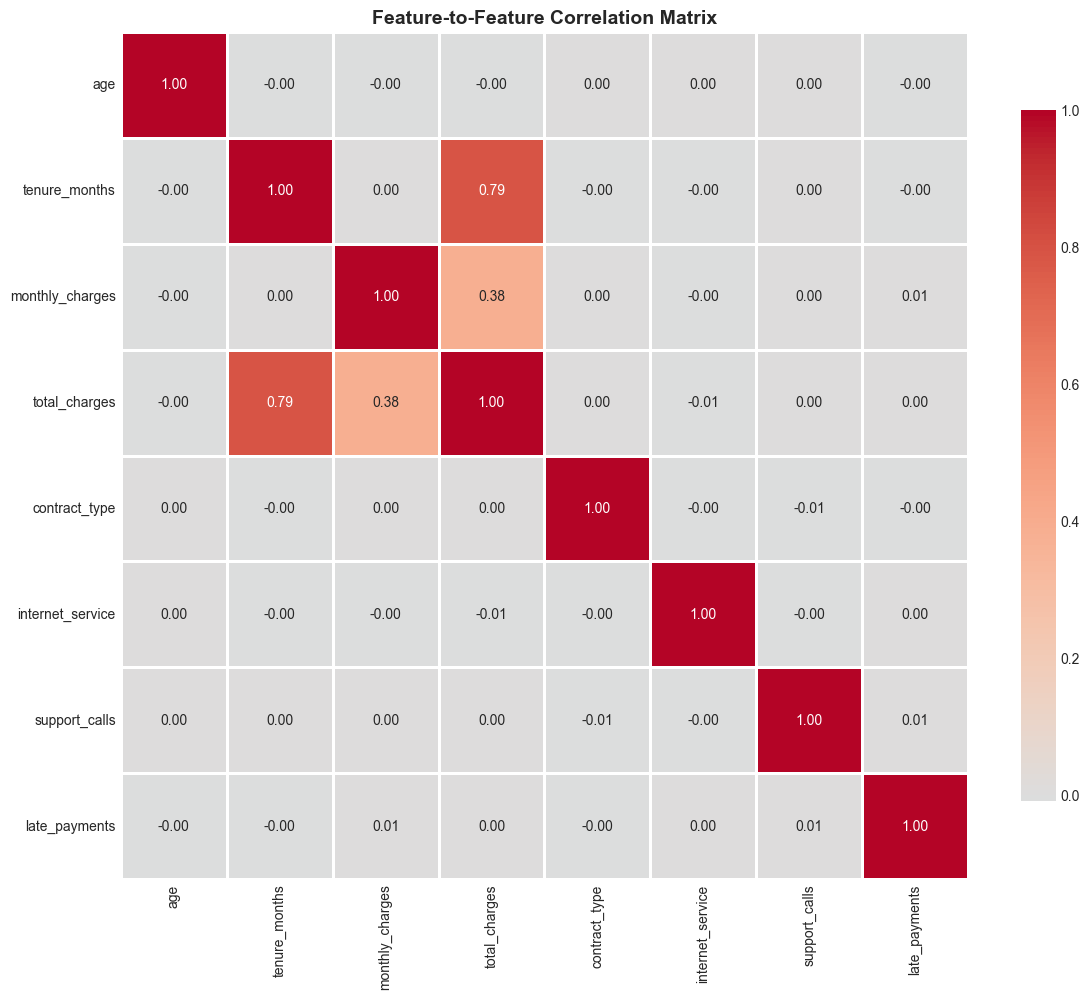

In [18]:
# Feature-to-feature correlation (multicollinearity check)
print("\nFeature-to-Feature Correlation Matrix\n")
print("="*80)

corr_matrix = X_train.corr()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

print("Highly correlated feature pairs (|r| > 0.8):")
if high_corr_pairs:
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: {corr:.4f}")
else:
    print("  None found")

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature-to-Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Wrapper Methods

### 4.1 Recursive Feature Elimination (RFE)

Recursive Feature Elimination (RFE) - Logistic Regression

Optimal number of features: 5

Selected features:
['tenure_months', 'contract_type', 'internet_service', 'support_calls', 'late_payments']

Feature Rankings:
            Feature  Ranking  Selected
1     tenure_months        1      True
6     support_calls        1      True
5  internet_service        1      True
4     contract_type        1      True
7     late_payments        1      True
3     total_charges        2     False
0               age        3     False
2   monthly_charges        4     False


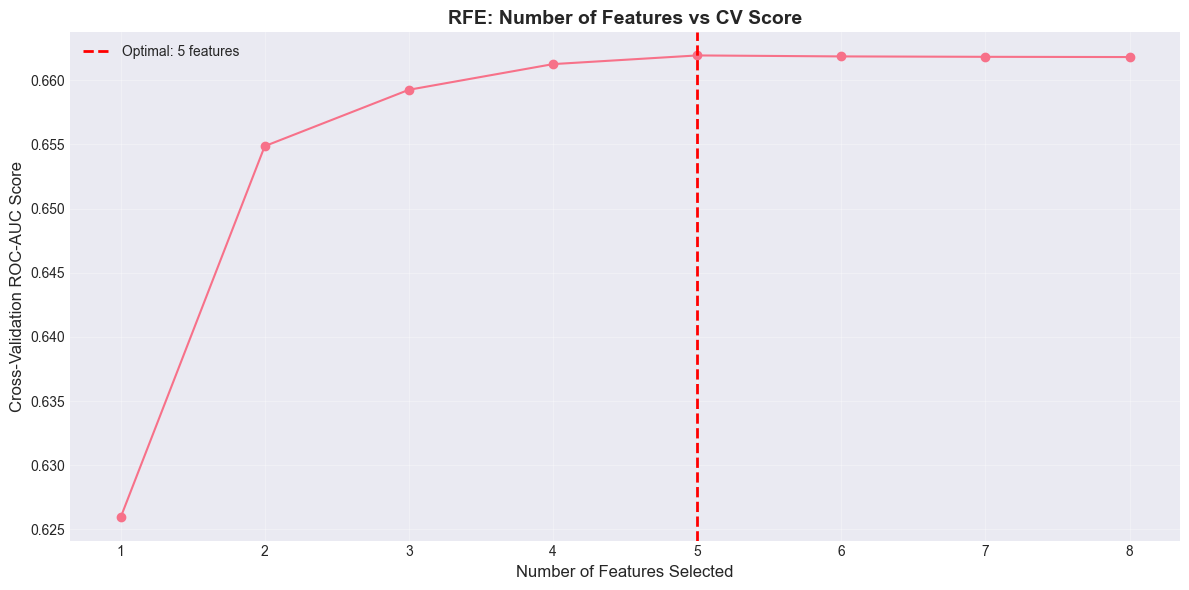

In [19]:
# RFE with Logistic Regression
print("Recursive Feature Elimination (RFE) - Logistic Regression\n")
print("="*80)

# Determine optimal number of features using RFECV
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
rfecv = RFECV(estimator=lr, step=1, cv=5, scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"\nSelected features:")
selected_features_rfe = X_train.columns[rfecv.support_].tolist()
print(selected_features_rfe)

# Feature ranking
rfe_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': rfecv.ranking_,
    'Selected': rfecv.support_
}).sort_values('Ranking')

print("\nFeature Rankings:")
print(rfe_ranking)

# Plot number of features vs cross-validation scores
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
         rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel('Number of Features Selected', fontsize=12)
plt.ylabel('Cross-Validation ROC-AUC Score', fontsize=12)
plt.title('RFE: Number of Features vs CV Score', fontsize=14, fontweight='bold')
plt.axvline(rfecv.n_features_, color='red', linestyle='--', 
            linewidth=2, label=f'Optimal: {rfecv.n_features_} features')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# RFE with Random Forest
print("\nRecursive Feature Elimination (RFE) - Random Forest\n")
print("="*80)

rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rfecv_rf = RFECV(estimator=rf, step=1, cv=5, scoring='roc_auc', n_jobs=-1)
rfecv_rf.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv_rf.n_features_}")
print(f"\nSelected features:")
selected_features_rfe_rf = X_train.columns[rfecv_rf.support_].tolist()
print(selected_features_rfe_rf)

# Feature ranking
rfe_rf_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': rfecv_rf.ranking_,
    'Selected': rfecv_rf.support_
}).sort_values('Ranking')

print("\nFeature Rankings:")
print(rfe_rf_ranking)


Recursive Feature Elimination (RFE) - Random Forest

Optimal number of features: 8

Selected features:
['age', 'tenure_months', 'monthly_charges', 'total_charges', 'contract_type', 'internet_service', 'support_calls', 'late_payments']

Feature Rankings:
            Feature  Ranking  Selected
0               age        1      True
1     tenure_months        1      True
2   monthly_charges        1      True
3     total_charges        1      True
4     contract_type        1      True
5  internet_service        1      True
6     support_calls        1      True
7     late_payments        1      True


### 4.2 Sequential Feature Selection

In [21]:
# Forward Selection
print("Sequential Feature Selection - Forward\n")
print("="*80)

lr_sfs = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
sfs = SequentialFeatureSelector(
    lr_sfs, 
    n_features_to_select='auto',
    direction='forward', 
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
sfs.fit(X_train_scaled, y_train)

selected_features_sfs = X_train.columns[sfs.get_support()].tolist()
print(f"Number of selected features: {len(selected_features_sfs)}")
print(f"\nSelected features:")
print(selected_features_sfs)

Sequential Feature Selection - Forward

Number of selected features: 4

Selected features:
['tenure_months', 'contract_type', 'internet_service', 'support_calls']


## 5. Embedded Methods - Tree-Based Feature Importance

### 5.1 Random Forest Feature Importance

Random Forest Feature Importance

            Feature  Importance
3     total_charges      0.2379
2   monthly_charges      0.2357
0               age      0.1734
1     tenure_months      0.1549
4     contract_type      0.0690
6     support_calls      0.0497
5  internet_service      0.0447
7     late_payments      0.0347


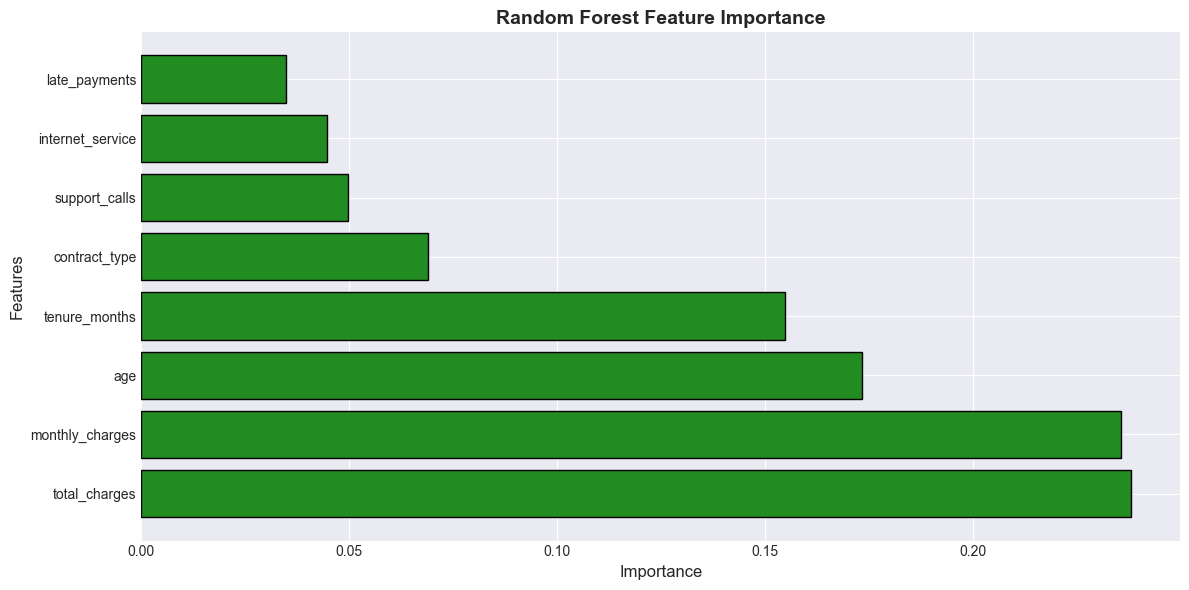


Random Forest Test Accuracy: 0.6344
Random Forest Test ROC-AUC: 0.6609


In [22]:
# Random Forest Feature Importance
print("Random Forest Feature Importance\n")
print("="*80)

rf_model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(rf_importance)

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(rf_importance['Feature'], rf_importance['Importance'], color='forestgreen', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate baseline score
y_pred_rf = rf_model.predict(X_test)
print(f"\nRandom Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest Test ROC-AUC: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]):.4f}")

### 5.2 Gradient Boosting Feature Importance

Gradient Boosting Feature Importance

            Feature  Importance
4     contract_type      0.4992
5  internet_service      0.3465
1     tenure_months      0.0658
6     support_calls      0.0488
7     late_payments      0.0147
3     total_charges      0.0125
2   monthly_charges      0.0075
0               age      0.0050


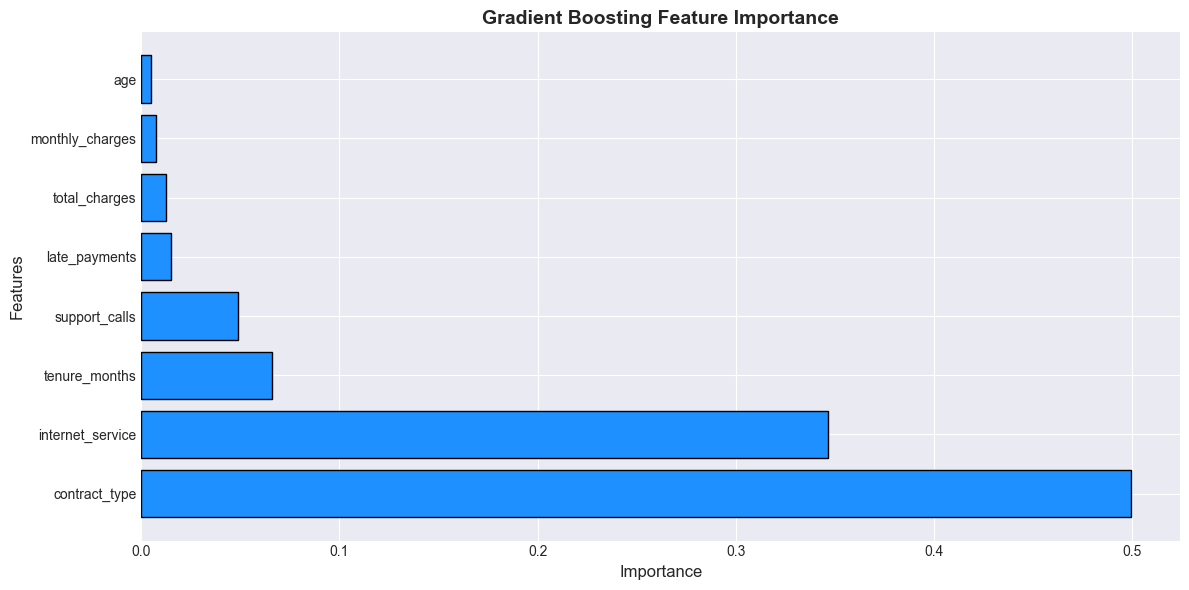

In [23]:
# Gradient Boosting Feature Importance
print("Gradient Boosting Feature Importance\n")
print("="*80)

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
gb_model.fit(X_train, y_train)

gb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(gb_importance)

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(gb_importance['Feature'], gb_importance['Importance'], color='dodgerblue', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Gradient Boosting Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5.3 Extra Trees Feature Importance

Extra Trees Feature Importance

            Feature  Importance
3     total_charges      0.2268
2   monthly_charges      0.2256
0               age      0.1861
1     tenure_months      0.1677
4     contract_type      0.0659
6     support_calls      0.0479
5  internet_service      0.0453
7     late_payments      0.0347


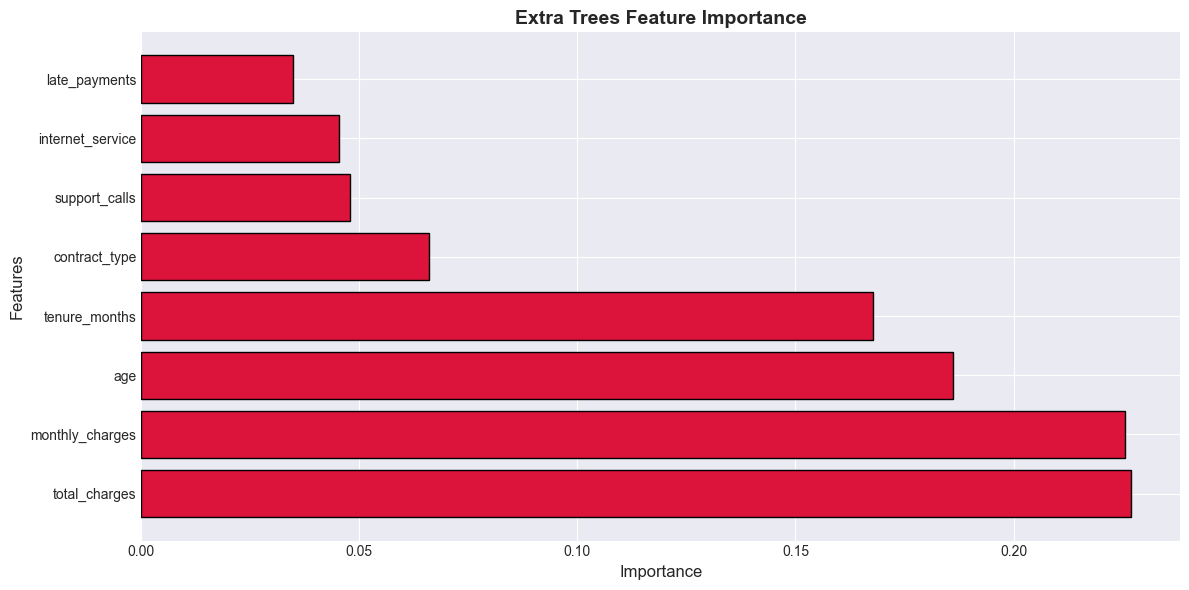

In [24]:
# Extra Trees Feature Importance
print("Extra Trees Feature Importance\n")
print("="*80)

et_model = ExtraTreesClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
et_model.fit(X_train, y_train)

et_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': et_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(et_importance)

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(et_importance['Feature'], et_importance['Importance'], color='crimson', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Extra Trees Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5.4 Permutation Importance

Permutation Importance (Random Forest)

            Feature  Importance_Mean  Importance_Std
4     contract_type           0.0500          0.0016
5  internet_service           0.0355          0.0026
0               age           0.0011          0.0018
6     support_calls           0.0004          0.0024
1     tenure_months          -0.0005          0.0021
7     late_payments          -0.0009          0.0017
2   monthly_charges          -0.0055          0.0018
3     total_charges          -0.0055          0.0013


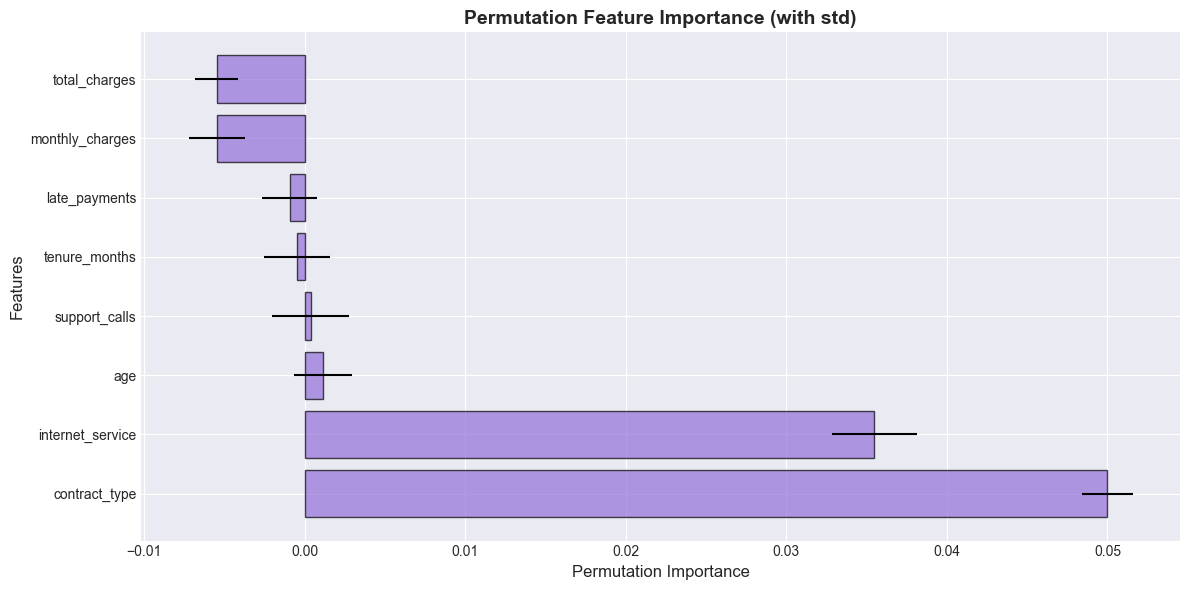

In [25]:
# Permutation Importance
print("Permutation Importance (Random Forest)\n")
print("="*80)

perm_importance = permutation_importance(
    rf_model, X_test, y_test, 
    n_repeats=10, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False)

print(perm_importance_df)

# Visualize with error bars
plt.figure(figsize=(12, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance_Mean'], 
         xerr=perm_importance_df['Importance_Std'], 
         color='mediumpurple', edgecolor='black', alpha=0.7)
plt.xlabel('Permutation Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Permutation Feature Importance (with std)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. L1 Regularization (Lasso) Feature Selection

L1 Regularization (Lasso) Feature Selection


C = 0.001:
  Features selected: 4
  Train accuracy: 0.6366
  Test accuracy: 0.6368

C = 0.01:
  Features selected: 5
  Train accuracy: 0.6373
  Test accuracy: 0.6373

C = 0.1:
  Features selected: 7
  Train accuracy: 0.6371
  Test accuracy: 0.6372

C = 1:
  Features selected: 8
  Train accuracy: 0.6371
  Test accuracy: 0.6371

C = 10:
  Features selected: 8
  Train accuracy: 0.6371
  Test accuracy: 0.6371

Best C value: 0.01

Lasso Feature Coefficients:
            Feature  Coefficient  Abs_Coefficient
4     contract_type      -0.5183           0.5183
5  internet_service       0.2086           0.2086
1     tenure_months      -0.1535           0.1535
6     support_calls       0.0920           0.0920
7     late_payments       0.0493           0.0493
3     total_charges       0.0000           0.0000
0               age       0.0000           0.0000
2   monthly_charges       0.0000           0.0000

Selected features by Lasso: 5
['contract_type

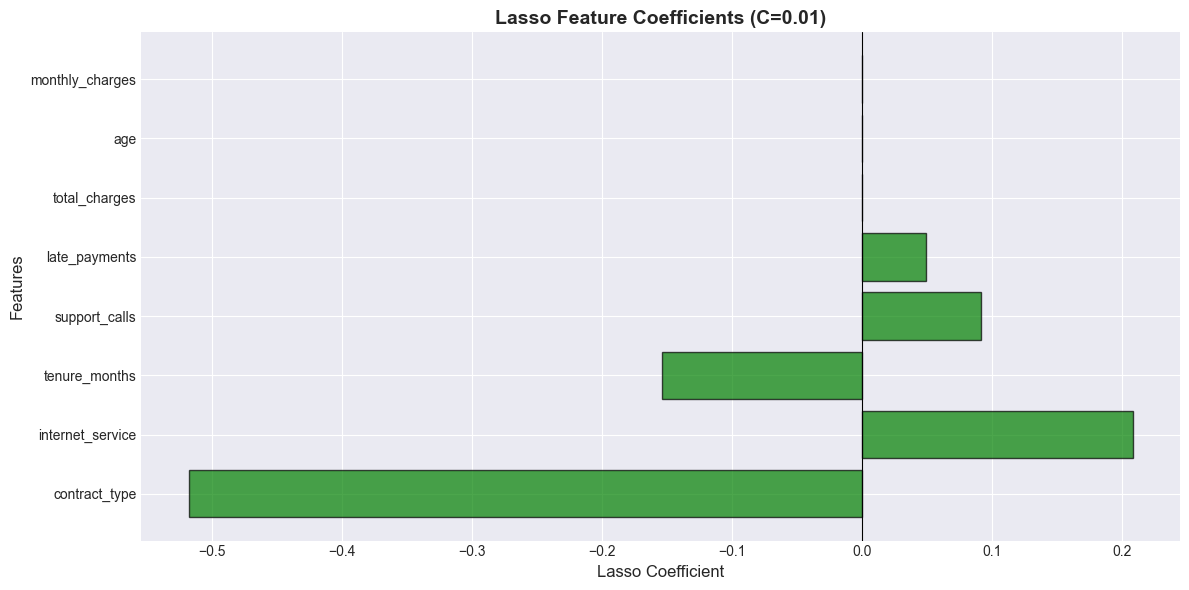

In [26]:
# L1 Regularization - Lasso
print("L1 Regularization (Lasso) Feature Selection\n")
print("="*80)

# Try different C values (inverse of regularization strength)
C_values = [0.001, 0.01, 0.1, 1, 10]

lasso_results = []

for C in C_values:
    lasso = LogisticRegression(penalty='l1', C=C, solver='liblinear', 
                               max_iter=1000, random_state=RANDOM_STATE)
    lasso.fit(X_train_scaled, y_train)
    
    # Count non-zero coefficients
    n_selected = np.sum(lasso.coef_ != 0)
    
    # Calculate performance
    train_score = lasso.score(X_train_scaled, y_train)
    test_score = lasso.score(X_test_scaled, y_test)
    
    lasso_results.append({
        'C': C,
        'N_Features': n_selected,
        'Train_Score': train_score,
        'Test_Score': test_score
    })
    
    print(f"\nC = {C}:")
    print(f"  Features selected: {n_selected}")
    print(f"  Train accuracy: {train_score:.4f}")
    print(f"  Test accuracy: {test_score:.4f}")

lasso_results_df = pd.DataFrame(lasso_results)

# Use best C value
best_C = lasso_results_df.loc[lasso_results_df['Test_Score'].idxmax(), 'C']
print(f"\nBest C value: {best_C}")

# Fit final model with best C
lasso_final = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', 
                                  max_iter=1000, random_state=RANDOM_STATE)
lasso_final.fit(X_train_scaled, y_train)

# Get feature importance
lasso_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_final.coef_[0],
    'Abs_Coefficient': np.abs(lasso_final.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nLasso Feature Coefficients:")
print(lasso_importance)

# Selected features (non-zero coefficients)
selected_features_lasso = lasso_importance[lasso_importance['Coefficient'] != 0]['Feature'].tolist()
print(f"\nSelected features by Lasso: {len(selected_features_lasso)}")
print(selected_features_lasso)

# Visualize
plt.figure(figsize=(12, 6))
colors = ['green' if c != 0 else 'red' for c in lasso_importance['Coefficient']]
plt.barh(lasso_importance['Feature'], lasso_importance['Coefficient'], 
         color=colors, edgecolor='black', alpha=0.7)
plt.xlabel('Lasso Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Lasso Feature Coefficients (C={best_C})', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

## 7. Comprehensive Feature Ranking

In [27]:
# Combine all feature importance scores
print("Comprehensive Feature Ranking\n")
print("="*80)

# Normalize all scores to 0-1 range
from sklearn.preprocessing import MinMaxScaler

scaler_norm = MinMaxScaler()

# Create comprehensive dataframe
comprehensive_ranking = pd.DataFrame({'Feature': X_train.columns})

# Add Chi-Square scores
comprehensive_ranking = comprehensive_ranking.merge(
    chi2_results[['Feature', 'Chi2_Score']].rename(columns={'Chi2_Score': 'Chi2'}),
    on='Feature', how='left'
)

# Add F-scores
comprehensive_ranking = comprehensive_ranking.merge(
    f_results[['Feature', 'F_Score']].rename(columns={'F_Score': 'ANOVA_F'}),
    on='Feature', how='left'
)

# Add Mutual Information
comprehensive_ranking = comprehensive_ranking.merge(
    mi_results[['Feature', 'MI_Score']].rename(columns={'MI_Score': 'Mutual_Info'}),
    on='Feature', how='left'
)

# Add Correlation
comprehensive_ranking = comprehensive_ranking.merge(
    corr_df[['Feature', 'Abs_Correlation']].rename(columns={'Abs_Correlation': 'Correlation'}),
    on='Feature', how='left'
)

# Add Random Forest importance
comprehensive_ranking = comprehensive_ranking.merge(
    rf_importance[['Feature', 'Importance']].rename(columns={'Importance': 'RF_Importance'}),
    on='Feature', how='left'
)

# Add Gradient Boosting importance
comprehensive_ranking = comprehensive_ranking.merge(
    gb_importance[['Feature', 'Importance']].rename(columns={'Importance': 'GB_Importance'}),
    on='Feature', how='left'
)

# Add Extra Trees importance
comprehensive_ranking = comprehensive_ranking.merge(
    et_importance[['Feature', 'Importance']].rename(columns={'Importance': 'ET_Importance'}),
    on='Feature', how='left'
)

# Add Permutation importance
comprehensive_ranking = comprehensive_ranking.merge(
    perm_importance_df[['Feature', 'Importance_Mean']].rename(columns={'Importance_Mean': 'Perm_Importance'}),
    on='Feature', how='left'
)

# Add Lasso coefficients
comprehensive_ranking = comprehensive_ranking.merge(
    lasso_importance[['Feature', 'Abs_Coefficient']].rename(columns={'Abs_Coefficient': 'Lasso_Coef'}),
    on='Feature', how='left'
)

# Normalize all scores
score_columns = ['Chi2', 'ANOVA_F', 'Mutual_Info', 'Correlation', 
                 'RF_Importance', 'GB_Importance', 'ET_Importance', 
                 'Perm_Importance', 'Lasso_Coef']

for col in score_columns:
    comprehensive_ranking[f'{col}_Norm'] = scaler_norm.fit_transform(
        comprehensive_ranking[[col]]
    )

# Calculate average rank
norm_columns = [f'{col}_Norm' for col in score_columns]
comprehensive_ranking['Average_Score'] = comprehensive_ranking[norm_columns].mean(axis=1)
comprehensive_ranking['Overall_Rank'] = comprehensive_ranking['Average_Score'].rank(ascending=False)

# Sort by average score
comprehensive_ranking = comprehensive_ranking.sort_values('Average_Score', ascending=False)

print("\nComprehensive Feature Ranking (Top Features):")
print(comprehensive_ranking[['Feature', 'Average_Score', 'Overall_Rank'] + score_columns].head(10))

print("\nAll Features:")
print(comprehensive_ranking[['Feature', 'Average_Score', 'Overall_Rank']])

Comprehensive Feature Ranking


Comprehensive Feature Ranking (Top Features):
            Feature  Average_Score  Overall_Rank      Chi2   ANOVA_F  \
4     contract_type         0.8146        1.0000 5095.6022 4416.2144   
5  internet_service         0.3692        2.0000  588.0635  801.1151   
3     total_charges         0.2994        3.0000       NaN  250.6037   
1     tenure_months         0.2778        4.0000       NaN  403.9572   
2   monthly_charges         0.2484        5.0000       NaN    0.0040   
0               age         0.2055        6.0000       NaN    0.0737   
6     support_calls         0.1054        7.0000       NaN  170.2360   
7     late_payments         0.0541        8.0000       NaN   54.0480   

   Mutual_Info  Correlation  RF_Importance  GB_Importance  ET_Importance  \
4       0.0331       0.2287         0.0690         0.4992         0.0659   
5       0.0255       0.0996         0.0447         0.3465         0.0453   
3       0.0026       0.0559         0.2379   

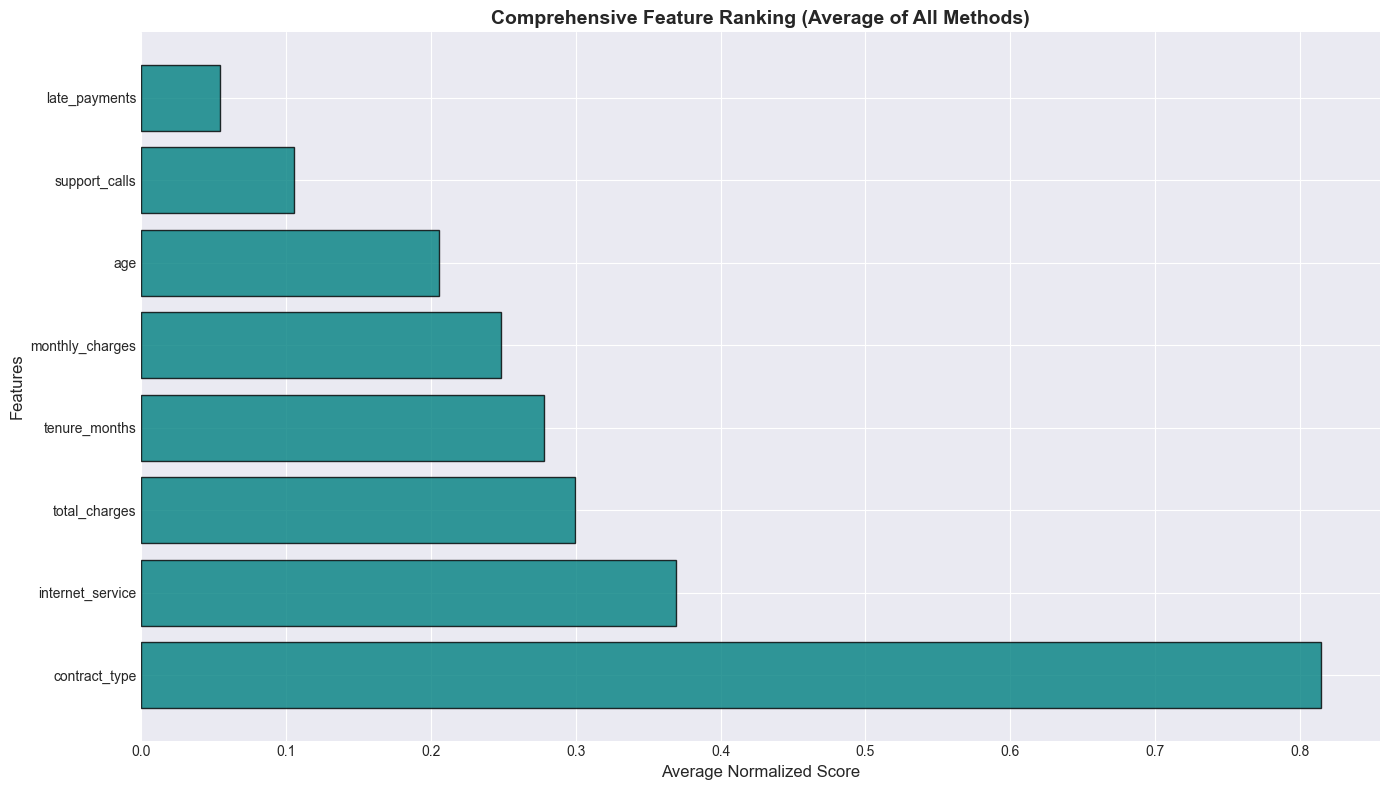

In [28]:
# Visualize comprehensive ranking
plt.figure(figsize=(14, 8))
plt.barh(comprehensive_ranking['Feature'], comprehensive_ranking['Average_Score'], 
         color='teal', edgecolor='black', alpha=0.8)
plt.xlabel('Average Normalized Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Comprehensive Feature Ranking (Average of All Methods)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

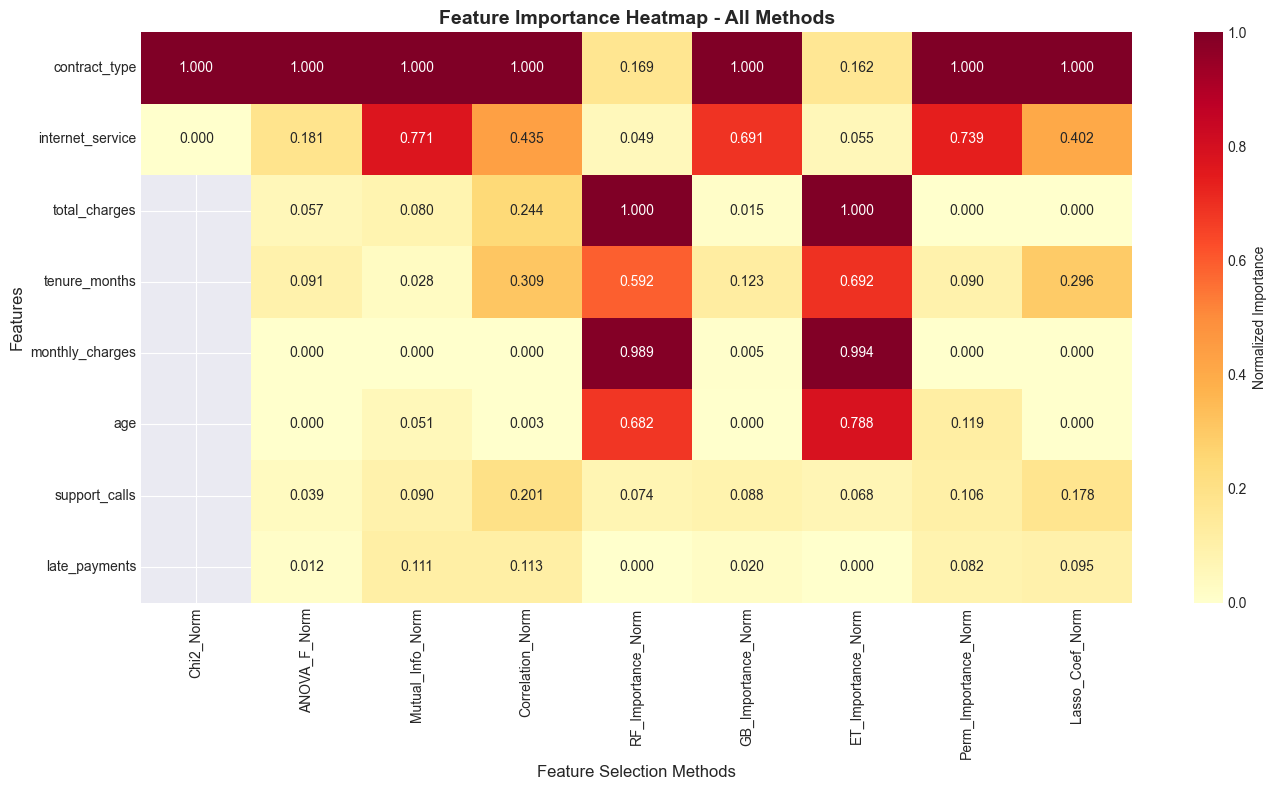

In [29]:
# Heatmap of all feature importance methods
plt.figure(figsize=(14, 8))
heatmap_data = comprehensive_ranking.set_index('Feature')[norm_columns]
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Normalized Importance'})
plt.title('Feature Importance Heatmap - All Methods', fontsize=14, fontweight='bold')
plt.xlabel('Feature Selection Methods', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

## 8. Final Feature Selection Recommendations

In [30]:
# Select top features based on different criteria
print("Feature Selection Recommendations\n")
print("="*80)

# Top 5 features
top_5_features = comprehensive_ranking.head(5)['Feature'].tolist()
print(f"\nTop 5 Features (by comprehensive ranking):")
for i, feat in enumerate(top_5_features, 1):
    score = comprehensive_ranking[comprehensive_ranking['Feature'] == feat]['Average_Score'].values[0]
    print(f"  {i}. {feat} (Score: {score:.4f})")

# Top 70% of features by cumulative importance
comprehensive_ranking['Cumulative_Score'] = comprehensive_ranking['Average_Score'].cumsum() / comprehensive_ranking['Average_Score'].sum()
top_70_features = comprehensive_ranking[comprehensive_ranking['Cumulative_Score'] <= 0.7]['Feature'].tolist()
print(f"\nTop features covering 70% cumulative importance: {len(top_70_features)}")
print(top_70_features)

# Features selected by majority of methods (appears in at least 5 out of 9 methods as top 50%)
print("\nFeatures consistently ranked high across methods:")
threshold = 0.5
consistently_high = []
for feat in comprehensive_ranking['Feature']:
    count = 0
    for col in norm_columns:
        if comprehensive_ranking[comprehensive_ranking['Feature'] == feat][col].values[0] >= threshold:
            count += 1
    if count >= 5:
        consistently_high.append(feat)

print(f"Features ranked in top 50% by at least 5 methods: {len(consistently_high)}")
print(consistently_high)

Feature Selection Recommendations


Top 5 Features (by comprehensive ranking):
  1. contract_type (Score: 0.8146)
  2. internet_service (Score: 0.3692)
  3. total_charges (Score: 0.2994)
  4. tenure_months (Score: 0.2778)
  5. monthly_charges (Score: 0.2484)

Top features covering 70% cumulative importance: 3
['contract_type', 'internet_service', 'total_charges']

Features consistently ranked high across methods:
Features ranked in top 50% by at least 5 methods: 1
['contract_type']


In [31]:
# Save feature selection results
comprehensive_ranking.to_csv('feature_selection_results.csv', index=False)
print("\nFeature selection results saved to 'feature_selection_results.csv'")

# Save top features for modeling
selected_features = {
    'top_5': top_5_features,
    'top_70_cumulative': top_70_features,
    'consistently_high': consistently_high,
    'rfe_logistic': selected_features_rfe,
    'rfe_random_forest': selected_features_rfe_rf,
    'lasso': selected_features_lasso
}

import json
with open('selected_features.json', 'w') as f:
    json.dump(selected_features, f, indent=2)

print("Selected features saved to 'selected_features.json'")


Feature selection results saved to 'feature_selection_results.csv'
Selected features saved to 'selected_features.json'


## 9. Summary and Insights

In [32]:
print("="*80)
print("FEATURE SELECTION SUMMARY")
print("="*80)

print("\n1. TOTAL FEATURES ANALYZED:")
print(f"   - Original features: {len(X_encoded.columns)}")
print(f"   - Numerical features: {len(numerical_features)}")
print(f"   - Categorical features: {len(categorical_features)}")

print("\n2. STATISTICAL TESTS:")
print(f"   - Chi-Square: {(chi2_results['Significant'] == 'Yes').sum()} significant features (p < 0.05)")
print(f"   - ANOVA F-Test: {(f_results['Significant'] == 'Yes').sum()} significant features (p < 0.05)")
print(f"   - Mutual Information: All features analyzed")

print("\n3. WRAPPER METHODS:")
print(f"   - RFE (Logistic): {len(selected_features_rfe)} features selected")
print(f"   - RFE (Random Forest): {len(selected_features_rfe_rf)} features selected")
print(f"   - Sequential Forward Selection: {len(selected_features_sfs)} features selected")

print("\n4. EMBEDDED METHODS:")
print(f"   - Random Forest: Top feature = {rf_importance.iloc[0]['Feature']} (importance: {rf_importance.iloc[0]['Importance']:.4f})")
print(f"   - Gradient Boosting: Top feature = {gb_importance.iloc[0]['Feature']} (importance: {gb_importance.iloc[0]['Importance']:.4f})")
print(f"   - Extra Trees: Top feature = {et_importance.iloc[0]['Feature']} (importance: {et_importance.iloc[0]['Importance']:.4f})")
print(f"   - Lasso (L1): {len(selected_features_lasso)} features with non-zero coefficients")

print("\n5. COMPREHENSIVE RANKING:")
print(f"   - Top 5 most important features:")
for i, feat in enumerate(top_5_features, 1):
    score = comprehensive_ranking[comprehensive_ranking['Feature'] == feat]['Average_Score'].values[0]
    print(f"     {i}. {feat} (Average Score: {score:.4f})")

print("\n6. RECOMMENDATIONS FOR MODELING:")
print(f"   - Use top {len(top_5_features)} features for simple models")
print(f"   - Use top {len(top_70_features)} features (70% cumulative) for balanced performance")
print(f"   - Use {len(consistently_high)} consistently high-ranked features for robust models")

print("\n" + "="*80)
print("END OF FEATURE SELECTION")
print("="*80)

FEATURE SELECTION SUMMARY

1. TOTAL FEATURES ANALYZED:
   - Original features: 8
   - Numerical features: 6
   - Categorical features: 2

2. STATISTICAL TESTS:
   - Chi-Square: 2 significant features (p < 0.05)
   - ANOVA F-Test: 6 significant features (p < 0.05)
   - Mutual Information: All features analyzed

3. WRAPPER METHODS:
   - RFE (Logistic): 5 features selected
   - RFE (Random Forest): 8 features selected
   - Sequential Forward Selection: 4 features selected

4. EMBEDDED METHODS:
   - Random Forest: Top feature = total_charges (importance: 0.2379)
   - Gradient Boosting: Top feature = contract_type (importance: 0.4992)
   - Extra Trees: Top feature = total_charges (importance: 0.2268)
   - Lasso (L1): 5 features with non-zero coefficients

5. COMPREHENSIVE RANKING:
   - Top 5 most important features:
     1. contract_type (Average Score: 0.8146)
     2. internet_service (Average Score: 0.3692)
     3. total_charges (Average Score: 0.2994)
     4. tenure_months (Average Score